In [381]:
import ee
import geemap
import hvplot.pandas
import hvplot.xarray
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
import holoviews as hv

In [61]:
ee.Authenticate()
ee.Initialize()

## Load RF-Regressor

In [477]:
asset_name = 'sosw_spm_rfregressor_sr_14052024'
folder_name = r'projects/ee-soswater/assets/classifiers'
asset_id = folder_name + '/' + asset_name
ee_rf_model = ee.Classifier.load(asset_id)

## Define sampling site

In [466]:
import geopandas as gpd
from shapely import wkt

#wkt_str = 'MultiPolygon (((105.98868591 13.5406822, 105.99085617 13.53431199, 105.98314277 13.53120747, 105.979839 13.53044141, 105.97458614 13.53182569, 105.97077091 13.53253798, 105.97202883 13.53839755, 105.97849814 13.53834379, 105.98314277 13.53894855, 105.98868591 13.5406822)))'
#wkt_str = 'MultiPolygon (((105.97663327 13.53842664, 105.9755172 13.53148996, 105.97224873 13.53207125, 105.96929913 13.53261379, 105.96818307 13.5327688, 105.96611038 13.53253629, 105.96696071 13.53916293, 105.97150469 13.53828455, 105.97525147 13.53834914, 105.97663327 13.53842664)))'
wkt_str = 'MultiPolygon (((105.96939214 13.53873666, 105.97381653 13.53841372, 105.97234173 13.53196791, 105.96823621 13.53274297, 105.96939214 13.53873666)))'
df = pd.DataFrame({
    'station_id': ['SKB'],
    'WKT': [wkt_str]
})
df['geometry'] = df.WKT.apply(wkt.loads)
df.drop('WKT', axis=1, inplace=True)
gdf_station = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# Plot
gdf_station.hvplot(geo=True, tiles='OSM', color='yellow', alpha=0.5, label='Sampling geometry')

:Overlay
   .WMTS.I                     :WMTS   [Longitude,Latitude]
   .Polygons.Sampling_geometry :Polygons   [Longitude,Latitude]

## Prepare imagery and apply model

In [478]:
start_date, end_date = '2000-01-01', '2024-07-05' # timespan to extract
cld_filt_thresh = 70 # scene-based cloud filter
cld_buffer, water_buffer = 250, 30 # cloud (grow) and water (erosion) buffer (meters)
watermask = 'index' # type of watermask to apply
gdrive_folder = r'E:\Google Drive\Earth Engine'
output_folder = 'SOSW_SPM_SR_samples_14052024'

In [479]:
%load_ext autoreload
%autoreload 2
import functions_process as funcs_process
import functions_turbidity as funcs_turb
import functions_sampling as funcs_sampling
from tqdm.notebook import tqdm

settings = {
    'start_date':       start_date,
    'end_date':         end_date,
    'cld_buffer':       cld_buffer,
    'water_buffer':     water_buffer,
    'cld_filt_thresh':  cld_filt_thresh,
    'watermask':        watermask,
    'harmonize_bnames': True,
    'add_indices':      True,
    'add_ratios':       True
}

fc_station = ee.FeatureCollection(geemap.gdf_to_ee(gdf_station))
fn = gdf_station.station_id.iloc[0]
bounds = fc_station.geometry()

ic_oli = funcs_process.load_sr_imcoll(sensor='oli', bounds=bounds, **settings)
fc_oli = ic_oli \
    .map(lambda img: img.classify(ee_rf_model).copyProperties(img) \
        .set('system:time_start', img.get('system:time_start'))) \
    .map(funcs_sampling.get_sample(bounds))

ic_etm = funcs_process.load_sr_imcoll(sensor='etm', bounds=bounds, **settings)
fc_etm = ic_etm \
    .map(lambda img: img.classify(ee_rf_model).copyProperties(img) \
        .set('system:time_start', img.get('system:time_start'))) \
    .map(funcs_sampling.get_sample(bounds))

ic_msi = funcs_process.load_sr_imcoll(sensor='msi', bounds=bounds, **settings)
fc_msi = ic_msi \
    .map(lambda img: img.classify(ee_rf_model).copyProperties(img) \
        .set('system:time_start', img.get('system:time_start'))) \
    .map(funcs_sampling.get_sample(bounds))

fc_samples = ee.FeatureCollection([fc_oli, fc_msi, fc_etm]).flatten() \

task = ee.batch.Export.table.toDrive(**{
    'collection': fc_samples, 
    'description': f'SR_{fn}',
    'folder': output_folder})
task.start()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import GEE data

In [469]:
import ast 

path_output = Path(gdrive_folder).joinpath(output_folder)
paths_csv = list(path_output.glob('*.csv'))

df = pd.DataFrame([])
for path in paths_csv:
    try:
        df_temp = pd.read_csv(path)
        df = pd.concat([df, df_temp])
    except pd.errors.EmptyDataError:
        print(f'Note: {path.name} was empty. Skipping.')
        continue # will skip the rest of the block and move to next file

def parse_str_dict(string):
    string = string.replace('=', '":').replace(', ', ', "').replace('null', 'None')[1:-1]
    string = '{"' + string +'}'
    parsed_dict = dict(ast.literal_eval(string))
    return parsed_dict

df['match_values'] = df.match_values.apply(parse_str_dict)
df_match_values = df['match_values'].apply(pd.Series)
df = pd.concat([df.drop('match_values', axis=1), df_match_values], axis=1)
# df.hvplot.scatter(x='add_ratio_rgb_mean', y='spm', c='match_td_days_abs', alpha=0.5, cmap='bwr')

# prep dataframe
df_samples = df.drop(columns=['.geo']).copy()
df_samples = df_samples.loc[~np.isnan(df_samples.classification_mean)]
df_samples.columns = df_samples.columns.str.replace(f'classification', 'spm', regex=True)
df_samples['dt_utc'] = pd.to_datetime(df_samples['dt_utc'], format='mixed')


## Read DSMP sediment data to validate

In [470]:
path_csv = r'E:\git\SOS-Water\WP3\T3.2\notebooks\mrc_webscrapper\outputs\csv\Sediment Flux\SedimentFlux.CalculatedDSMP@KH_SKB_[SekongBridge].csv'
df_dsmp_flux = pd.read_csv(path_csv)
df_dsmp_flux['date'] = pd.to_datetime(df_dsmp_flux['date'])

path_csv = r'E:\git\SOS-Water\WP3\T3.2\notebooks\mrc_webscrapper\outputs\csv\Sediment Concentration\SedimentConcentration.MeasuredDSMP@KH_SKB_[SekongBridge].csv'
df_dsmp_sedi = pd.read_csv(path_csv)
df_dsmp_sedi['date'] = pd.to_datetime(df_dsmp_sedi['date'])

path_csv = r'E:\git\SOS-Water\WP3\T3.2\notebooks\mrc_webscrapper\outputs\csv\Discharge\Discharge.MeasuredDSMP@KH_SKB_[SekongBridge].csv'
df_dsmp_q = pd.read_csv(path_csv)
df_dsmp_q['date'] = pd.to_datetime(df_dsmp_q['date'])

## Read CASCADE data
Read CASCADE file containing discharge (m3/s) measurements at Sekong Bridge.

C:\Users\Michael\AppData\Local\Temp\ipykernel_26836\3961144964.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = x[sorted_indices]
C:\Users\Michael\AppData\Local\Temp\ipykernel_26836\3961144964.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = y[sorted_indices]


Text(0.5, 1.0, 'Discharge validation')

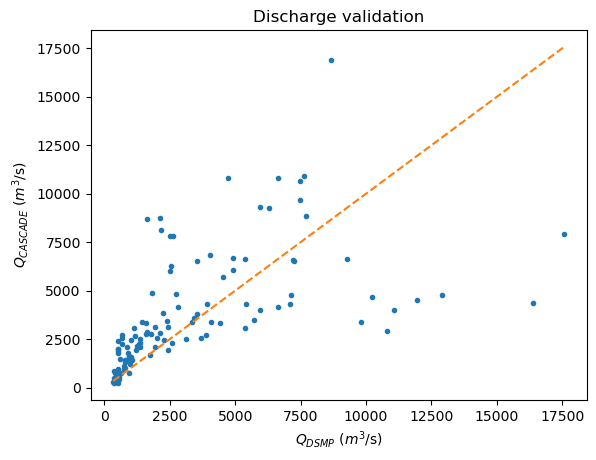

In [471]:
columns = ['year', 'month', 'day', 'discharge']
path_csv = 'data/cascade/SekongBridgeDischarge.day'
df_q = pd.read_csv(path_csv, skiprows=1, delimiter=r'\s+', names=columns)
df_q['date'] = pd.to_datetime(df_q['year'].astype(str) + '-' + 
                            df_q['month'].apply(lambda x: str(x).zfill(2)) + '-' + 
                            df_q['day'].apply(lambda x: str(x).zfill(2)))
df_q = df_q.drop(columns=['year', 'month', 'day'])

# Validate using DSMP
df_cascade_q_daily = df_q.set_index('date').resample('D').mean()
df_dsmp_q_daily = df_dsmp_q.set_index('date')[['value']].resample('D').mean()
df_dsmp_q_daily.index = df_dsmp_q_daily.index.date
df_q_val = pd.merge(df_cascade_q_daily, df_dsmp_q_daily, left_index=True, right_index=True).dropna()

# Plot 
x = df_q_val.value
y = df_q_val.discharge
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
plt.plot(x_sorted, y_sorted, '.', label="data", alpha=1)
plt.plot(x_sorted, x_sorted, '--', label="1:1")
plt.xlabel('$Q_{DSMP}$ ($m^{3}$/s)')
plt.ylabel('$Q_{CASCADE}$ ($m^{3}$/s)')
plt.title("Discharge validation")

## Interpolate gaps using sediment rating curves

In [473]:
df_spm_daily = df_samples.set_index('dt_utc').filter(regex='^spm').resample('D').mean()
df_q_daily = df_discharge.set_index('date').resample('D').mean()
df_est_daily = pd.merge(df_spm_daily, df_q_daily, left_index=True, right_index=True)

x_label = 'discharge'
y_label = 'spm_mean'
apply_log = True

window_size = 365.25*6
half_window = window_size // 2

df_interp_daily = df_est_daily.resample('D').mean()
df = df_interp_daily

# apply interpolation using time-dependent rating curve
for date, row in df.iterrows():
    if (~np.isnan(row[y_label])) | (np.isnan(row[x_label])):
        continue
    window_start = date - pd.Timedelta(days=half_window)
    window_end = date + pd.Timedelta(days=half_window)
    df_temp = df[(df.index >= window_start) & (df.index <= window_end)].dropna()
    
    if df_temp.shape[0] > 1:
        # Apply linear regression on log-log transform
        X = df_temp[x_label].values.reshape(-1, 1)
        y = df_temp[y_label].values
        if apply_log:
            X, y = np.log(X), np.log(y)
        model = LinearRegression()
        model.fit(X, y)
        if apply_log:
            prediction_log = model.predict(np.log1p([[df.loc[date, x_label]]]))[0]
            prediction = np.expm1(prediction_log)
        else:
            prediction = model.predict([[df.loc[date, x_label]]])[0]
        df.loc[date, y_label] = prediction
df_interp_daily = df

# calculate flux
# conversion q: m^3/s to m^3/day
# conversion spm: mg/L to kg/m^3
df_interp_daily['flux'] = (df_interp_daily[x_label]*24*60*60) * (df_interp_daily[y_label]/1000000)

C:\Users\Michael\AppData\Local\Temp\ipykernel_26836\4115519988.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = x[sorted_indices]
C:\Users\Michael\AppData\Local\Temp\ipykernel_26836\4115519988.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = y[sorted_indices]


Text(0.5, 1.0, 'SPM validation')

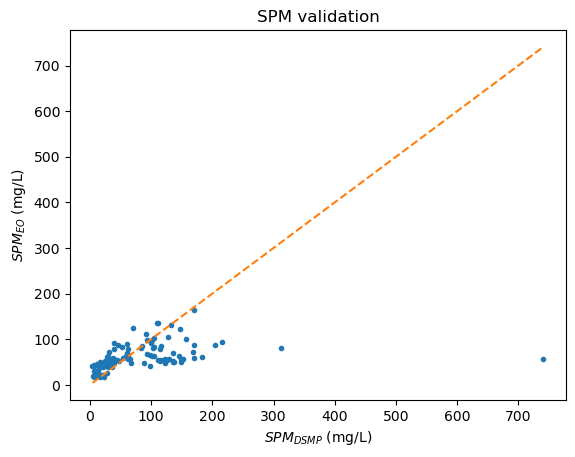

In [475]:
# Validate using DSMP
#df_dsmp_sedi_daily = df_dsmp_sedi.set_index('date')[['value']].resample('D').mean()
#df_dsmp_sedi_daily.index = df_dsmp_sedi_daily.index.date
df_q_val = pd.merge(df_dsmp_sedi_daily.dropna(), df_interp_daily, left_index=True, right_index=True)

# Plot 
x = df_q_val.value
y = df_q_val[y_label]
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
plt.plot(x_sorted, y_sorted, '.', label="data", alpha=1)
plt.plot(x_sorted, x_sorted, '--', label="1:1")
plt.ylabel('$SPM_{EO}$ (mg/L)')
plt.xlabel('$SPM_{DSMP}$ (mg/L)')
plt.title("SPM validation")

In [476]:
plot_spm = df_interp_daily.hvplot(y=y_label, label='SPM (q-interpolated)', color='black',
    width=1000, ylabel='SPM (mg/L)', title='SPM validation') * \
    df_est_daily.hvplot.scatter(y=y_label, label='SPM (EO-model)', color='red', marker='+') * \
    df_dsmp_sedi.hvplot.scatter(x='date', y='value', label='Sediment Concentration (DSMP)', color='green', marker='+') *\
    df_dsmp_sedi.set_index('date')['value'].resample('D').mean().interpolate(limit=14).hvplot(y='value', label='Sediment Concentration (DSMP)', color='green')
    
plot_flux = df_interp_daily.flux.hvplot(label='Flux (q-interpolated)', color='black',
    width=1000, ylabel='Sediment Flux (tonnes/day)', title='Flux validation (Sekong Bridge)') *\
    df_dsmp_flux.hvplot.scatter(x='date', y='value', label='Flux (DSMP)', marker='+', color='green') *\
    df_dsmp_flux.set_index('date')['value'].resample('D').mean().interpolate(limit=14).hvplot(y='value', label='Flux (DSMP)', color='green')

plot_q = df_q.hvplot(x='date', y='discharge', label='Q (CASCADE)', color='black',
    width=1000, ylabel='Discharge (m^3/s)', title='Discharge validation (Sekong Bridge)') * \
    df_dsmp_q.hvplot.scatter(x='date', y='value', label='Q (DSMP)', marker='+', color='green') * \
    df_dsmp_q.set_index('date')['value'].resample('D').mean().interpolate(limit=14).hvplot(y='value', label='Q (DSMP)', color='green')

plots = hv.Layout([plot_spm, plot_q, plot_flux]).cols(1).opts(shared_axes=False)
plots

:Layout
   .Overlay.I   :Overlay
      .Curve.SPM_left_parenthesis_q_hyphen_minus_interpolated_right_parenthesis :Curve   [index]   (spm_mean)
      .Scatter.SPM_left_parenthesis_EO_hyphen_minus_model_right_parenthesis     :Scatter   [index]   (spm_mean)
      .Scatter.Sediment_Concentration_left_parenthesis_DSMP_right_parenthesis   :Scatter   [date]   (value)
      .Curve.Sediment_Concentration_left_parenthesis_DSMP_right_parenthesis     :Curve   [date]   (value)
   .Overlay.II  :Overlay
      .Curve.Q_left_parenthesis_CASCADE_right_parenthesis :Curve   [date]   (discharge)
      .Scatter.Q_left_parenthesis_DSMP_right_parenthesis  :Scatter   [date]   (value)
      .Curve.Q_left_parenthesis_DSMP_right_parenthesis    :Curve   [date]   (value)
   .Overlay.III :Overlay
      .Curve.Flux_left_parenthesis_q_hyphen_minus_interpolated_right_parenthesis :Curve   [index]   (flux)
      .Scatter.Flux_left_parenthesis_DSMP_right_parenthesis                      :Scatter   [date]   (value)
      .Curve.Flux_left_parenthesis_DSMP_right_parenthesis                        :Curve   [date]   (value)

In [240]:
# (df_merge_daily['discharge']/df_merge_daily['spm_mean']).hvplot(label='daily_ratio') * \
# (df_merge_daily['discharge']/df_merge_daily['spm_mean']).rolling(pd.Timedelta(365.25, 'days'), center=True).median().hvplot(label='daily_ratio (rolling med)')

:Overlay
   .Curve.Daily_ratio                                                :Curve   [index]   (0)
   .Curve.Daily_ratio_left_parenthesis_rolling_med_right_parenthesis :Curve   [index]   (0)

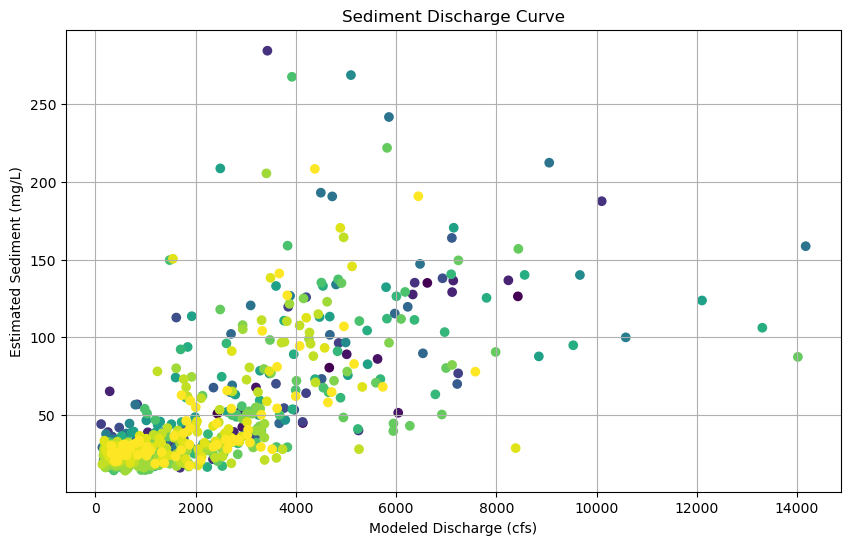

In [398]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_merge_daily['discharge'], df_merge_daily['spm_mean'], c=df_merge_daily['year'])
plt.xlabel('Modeled Discharge (cfs)')
plt.ylabel('Estimated Sediment (mg/L)')
plt.title('Sediment Discharge Curve')
plt.grid(True)
plt.show()

In [179]:
merged_df.index.year

Index([2001, 2001, 2001, 2001, 2001, 2001, 2001, 2002, 2002, 2002,
       ...
       2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022],
      dtype='int32', length=763)

Detected changes: [(2001, 2002), (2002, 2003), (2004, 2005), (2005, 2006), (2006, 2007), (2007, 2008), (2008, 2009), (2009, 2010), (2010, 2011), (2012, 2013), (2013, 2014), (2014, 2015), (2015, 2016), (2016, 2017), (2017, 2018), (2018, 2019), (2019, 2020), (2020, 2021), (2021, 2022)]
Breakpoints: [2002, 2003, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


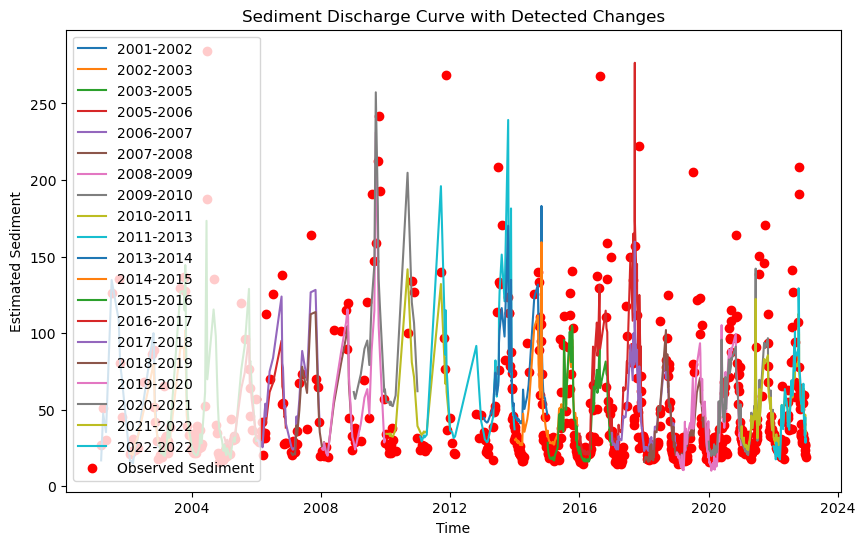

In [187]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

merged_df = df_merge_daily
merged_df['year'] = merged_df.index.year

q_label = 'discharge'
spm_label = 'spm_mean'

def fit_rating_curve(data):
    # Fit a linear regression model for sediment vs. discharge
    X = data[q_label].values.reshape(-1, 1)
    y = data[spm_label].values
    model = LinearRegression().fit(X, y)
    return model.coef_[0], model.intercept_

# Fit curves for each year
rating_curves = {}
for year, group in merged_df.groupby('year'):
    slope, intercept = fit_rating_curve(group)
    rating_curves[year] = (slope, intercept)

def detect_changes(rating_curves, threshold=0.9):
    changes = []
    years = sorted(rating_curves.keys())
    for i in range(1, len(years)):
        prev_year = years[i-1]
        curr_year = years[i]
        prev_slope, prev_intercept = rating_curves[prev_year]
        curr_slope, curr_intercept = rating_curves[curr_year]
        # Compute change in slope and intercept
        slope_change = abs(curr_slope - prev_slope)
        intercept_change = abs(curr_intercept - prev_intercept)
        # Check if change exceeds threshold
        if slope_change > threshold or intercept_change > threshold:
            changes.append((prev_year, curr_year))
    return changes

changes = detect_changes(rating_curves)
print("Detected changes:", changes)

breakpoints = [year for prev_year, year in changes]
print("Breakpoints:", breakpoints)

# Fit curves for each year
rating_curves = {}
for year, group in merged_df.groupby('year'):
    slope, intercept = fit_rating_curve(group)
    rating_curves[year] = (slope, intercept)

def interpolate_segment(data, slope, intercept):
    X = data[q_label].values.reshape(-1, 1)
    interpolated_sediment = slope * X + intercept
    return interpolated_sediment

# Plot the data with breakpoints and interpolation
plt.figure(figsize=(10, 6))
for start_year, end_year in zip([merged_df['year'].min()] + breakpoints, breakpoints + [merged_df['year'].max()]):
    segment = merged_df[(merged_df['year'] >= start_year) & (merged_df['year'] <= end_year)]
    slope, intercept = rating_curves[start_year]
    interpolated_sediment = interpolate_segment(segment, slope, intercept)
    plt.plot(segment.index, interpolated_sediment, label=f"{start_year}-{end_year}")

plt.scatter(merged_df.index, merged_df[spm_label], color='red', label='Observed Sediment')
plt.xlabel('Time')
plt.ylabel('Estimated Sediment')
plt.title('Sediment Discharge Curve with Detected Changes')
plt.legend()
plt.show()